# Bibliotecas

In [2]:
import pyedflib
import numpy as np
import pandas as pd
import commands
import pywt
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
from pywt import WaveletPacket
import pywt.data
from detect_peaks import detect_peaks
%matplotlib notebook

---

## Filtros

In [3]:
def FilterSignal(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = emg_filtered
    #emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    #return emg_envelope
    return emg_filtered

## Função FFT

In [74]:
def Fft(file_):
    
    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('DB_REPO/edf/'+file_)    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)

    file_name._close()

    df = pd.DataFrame(np.transpose(sigbufs))
    #df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    if len(df.columns) == 4:
        
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})
        df = df.rename(columns={3: 'Ch4'})
        
    if len(df.columns) == 3:

        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})
            

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    def fft(dfa):
        
        for i in range(dfa.shape[1]):
            if i == 0:
                Xc = np.abs(np.fft.fft(dfa[:, i]))
            else:
                Xcp = np.abs(np.fft.fft(dfa[:, i]))
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)
    
    
    #Aplica FFT em cada canal
    fft = fft(dfa)
    if len(df.columns) == 4:
        fft = pd.DataFrame(data=fft, columns=['Ch1','Ch2','Ch3','Ch4'])
    
    if len(df.columns) == 3:
        fft = pd.DataFrame(data=fft, columns=['Ch1','Ch2','Ch3'])
        
    return fft

In [5]:
def PlotFft(Xc, F):
    #Xc = dfn['Ch1']
    ff, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    fs = np.linspace(0, F,Xc['Ch1'].shape[0])
    ax1.plot(fs,Xc['Ch1'], linewidth=0.2, color = '#B22222')
    ax1.set_title('Tremor de Intensao'+'\nCanal 1')
    ax1.set_ylabel('EMG (u.v.)')
    ax1.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    fs = np.linspace(0, F,Xc['Ch2'].shape[0])
    ax2.plot(fs,Xc['Ch2'], linewidth=0.2, color = '#008000')
    ax2.set_title('\nCanal 2')
    ax2.set_ylabel('EMG (u.v.)')
    ax2.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    fs = np.linspace(0, F,Xc['Ch3'].shape[0])
    ax3.plot(fs,Xc['Ch3'], linewidth=0.2)
    ax3.set_title('\nCanal 3')
    ax3.set_ylabel('EMG (u.v.)')
    ax3.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    fs = np.linspace(0, F,Xc['Ch4'].shape[0])
    ax4.plot(fs,Xc['Ch4'], linewidth=0.2, color = '#FF8C00')
    ax4.set_title('\nCanal 4')
    ax4.set_ylabel('EMG (u.v.)')
    ax4.set_xlabel('Amostras')
    ax4.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    plt.setp([a.get_xticklabels() for a in ff.axes[:-1]], visible=False)
    ff.set_size_inches(w=10,h=8)

## Função Plot

In [6]:
def PlotFile(dfn):
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    ax1.plot(dfn['Ch1'][2000:], linewidth=0.2, color = '#B22222')
    ax1.set_title('Tremor de Intensao'+'\nCanal 1')
    ax1.set_ylabel('EMG (u.v.)')
    ax1.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax2.plot(dfn['Ch2'][2000:], linewidth=0.2, color = '#008000')
    ax2.set_title('\nCanal 2')
    ax2.set_ylabel('EMG (u.v.)')
    ax2.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax3.plot(dfn['Ch3'][2000:], linewidth=0.2)
    ax3.set_title('\nCanal 3')
    ax3.set_ylabel('EMG (u.v.)')
    ax3.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax4.plot(dfn['Ch4'][2000:], linewidth=0.2, color = '#FF8C00')
    ax4.set_title('\nCanal 4')
    ax4.set_ylabel('EMG (u.v.)')
    ax4.set_xlabel('Amostras')
    ax4.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    f.set_size_inches(w=10,h=8)

## Função RMS

In [26]:
def Rms(file_):

    #Calcula RMS
    def rms(a, window_size):
        def subrms(a, window_size):
            a2 = np.power(a,2)
            window = np.ones(window_size)/float(window_size)
            return np.sqrt(np.convolve(a2, window, 'valid'))

        for i in range(a.shape[1]):
            if i == 0:
                Xc = subrms(a[:, i], window_size)
            else:
                Xcp = subrms(a[:, i], window_size)
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)
    
    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('DB_REPO/edf/'+file_)    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)

    file_name._close()

    df = pd.DataFrame(np.transpose(sigbufs))
    #df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    if len(df.columns) == 4:
        
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})
        df = df.rename(columns={3: 'Ch4'})
        
    if len(df.columns) == 3:

        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})
            

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    #Aplica RMS em cada canal
    rms = rms(dfa,50)
    if len(df.columns) == 4:
        rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3','Ch4'])
    
    if len(df.columns) == 3:
        rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3'])
        
    return rms

---

In [10]:
import commands
A = commands.getoutput('ls DB_REPO/edf')
A.split('\n')

['Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf',
 'Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf',
 'Arthur Araujo Filho - Dia 17.11.18 as 16.13.01.edf',
 'Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf',
 'Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.26.edf',
 'Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.46.edf',
 'Carmino Pereira da Silva - Dia 17.11.18 as 15.36.47.edf',
 'Carmino Pereira da Silva - Dia 17.11.18 as 15.37.03.edf',
 'Carmino Pereira da Silva - Dia 17.11.18 as 15.37.25.edf',
 'Diniz Esmeraldo - Dia 17.11.08 as 16.34.34.edf',
 'Diniz Esmeraldo - Dia 17.11.08 as 16.34.49.edf',
 'Diniz Esmeraldo - Dia 17.11.08 as 16.35.03.edf',
 'Donia Aires - Dia 17.11.25 as 16.39.51.edf',
 'Donia Aires - Dia 17.11.25 as 16.40.23.edf',
 'Donia Aires - Dia 17.11.25 as 16.40.42.edf',
 'Fernando Francisco da Silva - Dia 17.11.18 as 17.05.58.edf',
 'Fernando Francisco da Silva - Dia 17.11.18 as 17.06.14.edf',
 'Fernando Francisco da Silva - Dia 17.11.18 as 17.06.32.edf',
 

In [11]:
files = ['Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf',
 'Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf',
 'Arthur Araujo Filho - Dia 17.11.18 as 16.13.01.edf',
 'Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf',
 'Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.26.edf',
 'Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.46.edf',
 'Carmino Pereira da Silva - Dia 17.11.18 as 15.36.47.edf',
 'Carmino Pereira da Silva - Dia 17.11.18 as 15.37.03.edf',
 'Carmino Pereira da Silva - Dia 17.11.18 as 15.37.25.edf',
 'Diniz Esmeraldo - Dia 17.11.08 as 16.34.34.edf',
 'Diniz Esmeraldo - Dia 17.11.08 as 16.34.49.edf',
 'Diniz Esmeraldo - Dia 17.11.08 as 16.35.03.edf',
 'Donia Aires - Dia 17.11.25 as 16.39.51.edf',
 'Donia Aires - Dia 17.11.25 as 16.40.23.edf',
 'Donia Aires - Dia 17.11.25 as 16.40.42.edf',
 'Fernando Francisco da Silva - Dia 17.11.18 as 17.05.58.edf',
 'Fernando Francisco da Silva - Dia 17.11.18 as 17.06.14.edf',
 'Fernando Francisco da Silva - Dia 17.11.18 as 17.06.32.edf',
 'Gastao Goncalves da Silva - Dia 17.11.18 as 16.27.35.edf',
 'Gastao Goncalves da Silva - Dia 17.11.18 as 16.27.56.edf',
 'Gastao Goncalves da Silva - Dia 17.11.18 as 16.28.12.edf',
 'Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.58.28.edf',
 'Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.58.44.edf',
 'Ismael Rodrigues do Carmo - Dia 17.11.18 as 14.59.09.edf',
 'Ivanildes Barbosa - Dia 17.11.18 as 16.44.01.edf',
 'Ivanildes Barbosa - Dia 17.11.18 as 16.44.19.edf',
 'Ivanildes Barbosa - Dia 17.11.18 as 16.44.37.edf',
 'Jose Fernandes Araujo - Dia 17.11.25 as 17.15.42.edf',
 'Jose Fernandes Araujo - Dia 17.11.25 as 17.16.0.edf',
 'Jose Fernandes Araujo - Dia 17.11.25 as 17.16.28.edf',
 'Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.21.edf',
 'Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.34.edf',
 'Jose Francisto Fontineli  - Dia 17.11.11 as 16.56.49.edf',
 'Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.18.51.edf',
 'Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.19.07.edf',
 'Marcilio Pontinho de Rezende - Dia 17.11.11 as 16.19.23.edf',
 'Osvaldir Borborema - Dia 17.11.18 as 15.14.36.edf',
 'Osvaldir Borborema - Dia 17.11.18 as 15.14.58.edf',
 'Osvaldir Borborema - Dia 17.11.18 as 15.15.13.edf',
 'Sergio Lamenza - Dia 17.11.25 as 16.58.15.edf',
 'Sergio Lamenza - Dia 17.11.25 as 16.58.34.edf',
 'Sergio Lamenza - Dia 17.11.25 as 16.59.00.edf']

## Calcula a Norma de cada canal

In [18]:
#files = ['p1', 'p2', 'p3', 'p4', 'p5', 'c1', 'c2', 'c3', 'c4', 'c5']


peaks_rms_4ch = [ ]
peaks_rms_3ch = [ ]



def Norm(file_):
    
    #Calcula RMS
    def rms(a, window_size):
        def subrms(a, window_size):
            a2 = np.power(a,2)
            window = np.ones(window_size)/float(window_size)
            return np.sqrt(np.convolve(a2, window, 'valid'))

        for i in range(a.shape[1]):
            if i == 0:
                Xc = subrms(a[:, i], window_size)
            else:
                Xcp = subrms(a[:, i], window_size)
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)  

    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('DB_REPO/edf/'+file_)    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)

    file_name._close()

    df = pd.DataFrame(np.transpose(sigbufs))
    #df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    if len(df.columns) == 4:
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})
        df = df.rename(columns={3: 'Ch4'})


    if len(df.columns) == 3:
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    #Aplica RMS em cada canal
    rms = rms(dfa,50)
    if len(df.columns) == 4:
        rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3','Ch4'])
        
        #Calcula o pico RMS máximo de cada canal em cada arquivo e adiciona a lista peaks_rms
        peaks_rms_4ch.append([max(rms['Ch1']),max(rms['Ch2']),max(rms['Ch3']),max(rms['Ch4']),])
    
    if len(df.columns) == 4:
        rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3'])
        
        #Calcula o pico RMS máximo de cada canal em cada arquivo e adiciona a lista peaks_rms
        peaks_rms_3ch.append([max(rms['Ch1']),max(rms['Ch2']),max(rms['Ch3']),])
        
    return df

#Cria a lista de picos RMS máximo    
for i in files:
    Norm(i)

#Calcula o máximo global
peaks_rms_4ch = pd.DataFrame(data=peaks_rms_4ch, columns=['Ch1','Ch2','Ch3','Ch4'])
norm_4ch = [max(peaks_rms_4ch['Ch1']),max(peaks_rms_4ch['Ch2']),max(peaks_rms_4ch['Ch3']),max(peaks_rms_4ch['Ch4'])]  

peaks_rms_3ch = pd.DataFrame(data=peaks_rms_3ch, columns=['Ch1','Ch2','Ch3'])
norm_3ch = [max(peaks_rms_3ch['Ch1']),max(peaks_rms_3ch['Ch2']),max(peaks_rms_3ch['Ch3'])]  

norm = norm_3ch + norm_4ch
print 'Norma de cada canal: \n',norm

Norma de cada canal: 
[473.6481195965282, 2960.1764354868283, 108.6647994824209, 473.6481195965282, 2960.1764354868283, 108.6647994824209, 1679.2835958385861]


---

## Aplica a norma em cada amostra e salva

In [19]:
def Std(file_):

    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('DB_REPO/edf/'+file_)    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)

    file_name._close()

    df = pd.DataFrame(np.transpose(sigbufs))
    dfa = df.as_matrix()
    
    if len(df.columns) == 4:

        #Aplica a norma em cada canal
        Xc=np.array([dfa[:,0]/norm_4ch[0],dfa[:,1]/norm_4ch[1],dfa[:,2]/norm_4ch[2],dfa[:,3]/norm_4ch[3]])
        Xc = np.transpose(Xc)
        #Salva o arquivo normalizado na pasta <preproc>
        np.save('./DB_REPO/preproc/'+file_+'_std', Xc, allow_pickle=False)
        print file_+'_std.npy'

        return(pd.DataFrame(data=Xc, columns=['Ch1','Ch2','Ch3','Ch4']))
    
    if len(df.columns) == 3:

        #Aplica a norma em cada canal
        Xc=np.array([dfa[:,0]/norm_3ch[0],dfa[:,1]/norm_3ch[1],dfa[:,2]/norm_3ch[2]])
        Xc = np.transpose(Xc)
        #Salva o arquivo normalizado na pasta <preproc>
        np.save('./DB_REPO/preproc/'+file_+'_std', Xc, allow_pickle=False)
        print file_+'_std.npy'

        return(pd.DataFrame(data=Xc, columns=['Ch1','Ch2','Ch3']))

In [20]:
for i in files:
    Std(i)

Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_std.npy
Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf_std.npy
Arthur Araujo Filho - Dia 17.11.18 as 16.13.01.edf_std.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf_std.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.26.edf_std.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.46.edf_std.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.36.47.edf_std.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.37.03.edf_std.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.37.25.edf_std.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.34.34.edf_std.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.34.49.edf_std.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.35.03.edf_std.npy
Donia Aires - Dia 17.11.25 as 16.39.51.edf_std.npy
Donia Aires - Dia 17.11.25 as 16.40.23.edf_std.npy
Donia Aires - Dia 17.11.25 as 16.40.42.edf_std.npy
Fernando Francisco da Silva - Dia 17.11.18 as 17.05.58.edf_std.npy
Fernando Francisco da Silva - Dia 17.11.18 as 17.06.14.edf_std.

In [21]:
Std('Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf').head()

Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_std.npy


,Ch1,Ch2,Ch3,Ch4
0,0.022327,-0.001221,0.186603,0.017612
1,0.019318,-0.001221,0.186603,0.015084
2,0.025335,0.000705,0.173561,0.024354
3,0.016310,-0.000258,0.173561,0.013398
4,0.022327,0.000224,0.199644,0.015926


In [22]:
c = np.load('DB_REPO/preproc/Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_std.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

,Ch1,Ch2,Ch3,Ch4
0,0.022327,-0.001221,0.186603,0.017612
1,0.019318,-0.001221,0.186603,0.015084
2,0.025335,0.000705,0.173561,0.024354
3,0.016310,-0.000258,0.173561,0.013398
4,0.022327,0.000224,0.199644,0.015926


<IPython.core.display.Javascript object>


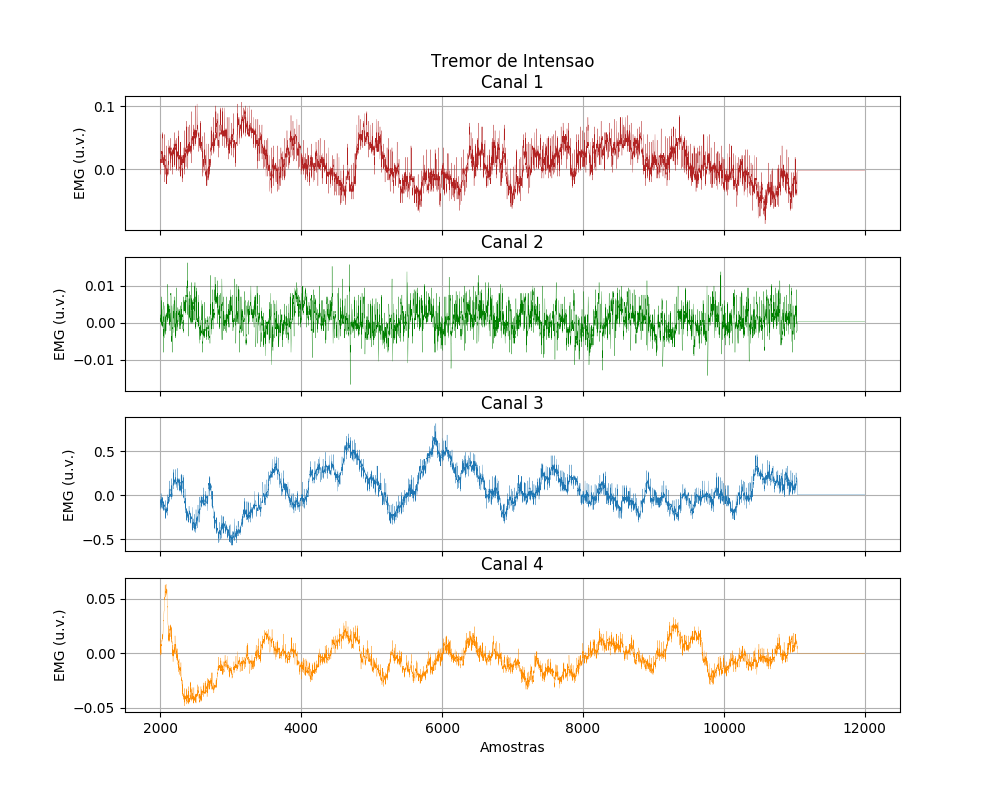

In [23]:
PlotFile(dfn)

In [57]:
for i in files:
    Xc = Rms(i)
    np.save('./DB_REPO/preproc/'+i+'_rms', Xc, allow_pickle=False)
    print i+'_rms.npy'

Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_rms.npy
Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf_rms.npy
Arthur Araujo Filho - Dia 17.11.18 as 16.13.01.edf_rms.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf_rms.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.26.edf_rms.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.46.edf_rms.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.36.47.edf_rms.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.37.03.edf_rms.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.37.25.edf_rms.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.34.34.edf_rms.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.34.49.edf_rms.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.35.03.edf_rms.npy
Donia Aires - Dia 17.11.25 as 16.39.51.edf_rms.npy
Donia Aires - Dia 17.11.25 as 16.40.23.edf_rms.npy
Donia Aires - Dia 17.11.25 as 16.40.42.edf_rms.npy
Fernando Francisco da Silva - Dia 17.11.18 as 17.05.58.edf_rms.npy
Fernando Francisco da Silva - Dia 17.11.18 as 17.06.14.edf_rms.

In [59]:
c = np.load('DB_REPO/preproc/Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_rms.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

,Ch1,Ch2,Ch3,Ch4
0,11.446258,13.161945,24.856702,19.817440
1,11.403695,13.155661,24.961891,19.516842
2,11.341954,13.177480,25.011108,19.332502
3,11.341954,13.261443,25.167758,18.626781
4,11.657292,13.429970,25.293589,18.562591


In [60]:
Rms('Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf').head()

,Ch1,Ch2,Ch3,Ch4
0,11.446258,13.161945,24.856702,19.817440
1,11.403695,13.155661,24.961891,19.516842
2,11.341954,13.177480,25.011108,19.332502
3,11.341954,13.261443,25.167758,18.626781
4,11.657292,13.429970,25.293589,18.562591


<IPython.core.display.Javascript object>


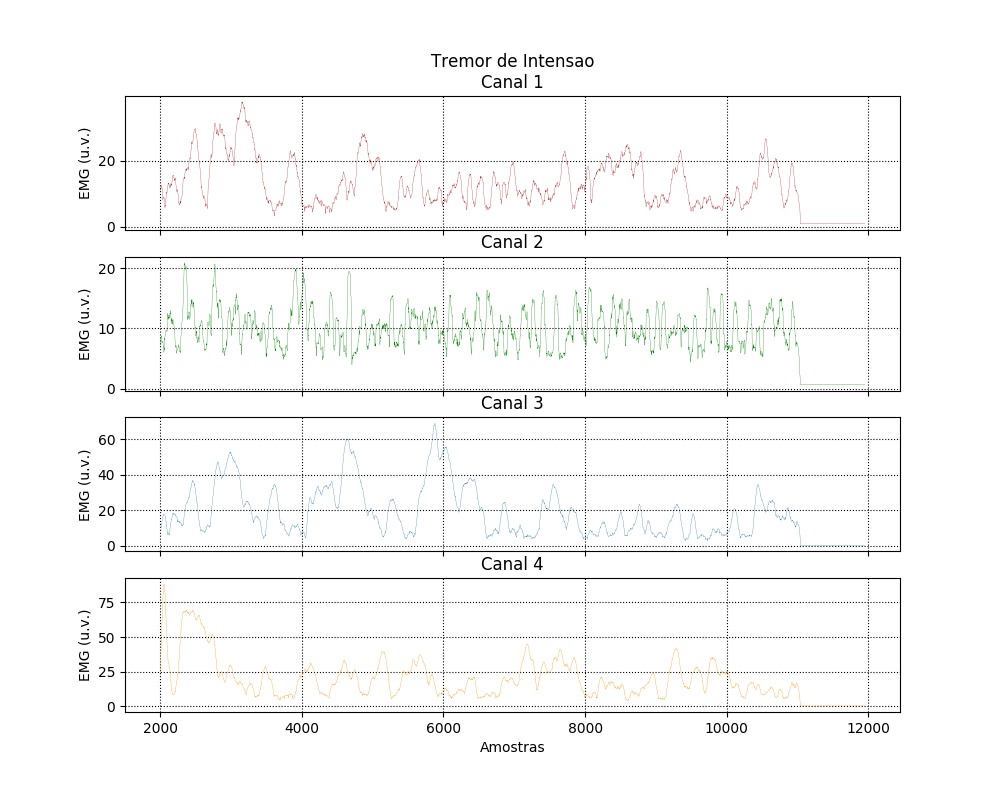

In [61]:
PlotFile(dfn)

In [62]:
for i in files:
    c = np.load('DB_REPO/preproc/'+i+'_rms.npy')
    
    if c.shape[1] ==  4:
        df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})
        df = df.rename(columns={3: 'Ch4'})

        Xc = df.copy()
        Xc['Ch1'] = FilterSignal(df['Ch1'], low_pass=10)
        Xc['Ch2'] = FilterSignal(df['Ch2'], low_pass=10)
        Xc['Ch3'] = FilterSignal(df['Ch3'], low_pass=10)
        Xc['Ch4'] = FilterSignal(df['Ch4'], low_pass=10)

        np.save('./DB_REPO/preproc/'+i+'_filt', Xc, allow_pickle=False)
        print i+'_filt.npy'
        
    if c.shape[1] ==  3:
        df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3'])
        #Nomeia cada coluna "canal"
        df = df.rename(columns={0: 'Ch1'})
        df = df.rename(columns={1: 'Ch2'})
        df = df.rename(columns={2: 'Ch3'})

        Xc = df.copy()
        Xc['Ch1'] = FilterSignal(df['Ch1'], low_pass=10)
        Xc['Ch2'] = FilterSignal(df['Ch2'], low_pass=10)
        Xc['Ch3'] = FilterSignal(df['Ch3'], low_pass=10)

        np.save('./DB_REPO/preproc/'+i+'_filt', Xc, allow_pickle=False)
        print i+'_filt.npy'

Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_filt.npy
Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf_filt.npy
Arthur Araujo Filho - Dia 17.11.18 as 16.13.01.edf_filt.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf_filt.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.26.edf_filt.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.46.edf_filt.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.36.47.edf_filt.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.37.03.edf_filt.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.37.25.edf_filt.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.34.34.edf_filt.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.34.49.edf_filt.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.35.03.edf_filt.npy
Donia Aires - Dia 17.11.25 as 16.39.51.edf_filt.npy
Donia Aires - Dia 17.11.25 as 16.40.23.edf_filt.npy
Donia Aires - Dia 17.11.25 as 16.40.42.edf_filt.npy
Fernando Francisco da Silva - Dia 17.11.18 as 17.05.58.edf_filt.npy
Fernando Francisco da Silva - Dia 17.11.18 as 1

In [63]:
df.head()

,Ch1,Ch2,Ch3,Ch4
0,6.597465,7.768949,4.593906,6.015141
1,6.629415,7.789427,4.940825,5.924135
2,6.648476,7.803831,4.944842,5.847213
3,6.667482,7.783524,4.997472,5.835847
4,6.680182,7.806307,4.584044,5.831709


In [64]:
c = np.load('DB_REPO/preproc/Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_filt.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

,Ch1,Ch2,Ch3,Ch4
0,0.177580,0.159890,-0.286540,0.051892
1,0.137408,0.217005,-0.212902,-0.126882
2,0.147789,0.318284,-0.122926,-0.406303
3,0.282882,0.487074,-0.007218,-0.741849
4,0.552582,0.706690,0.125195,-0.980704


<IPython.core.display.Javascript object>


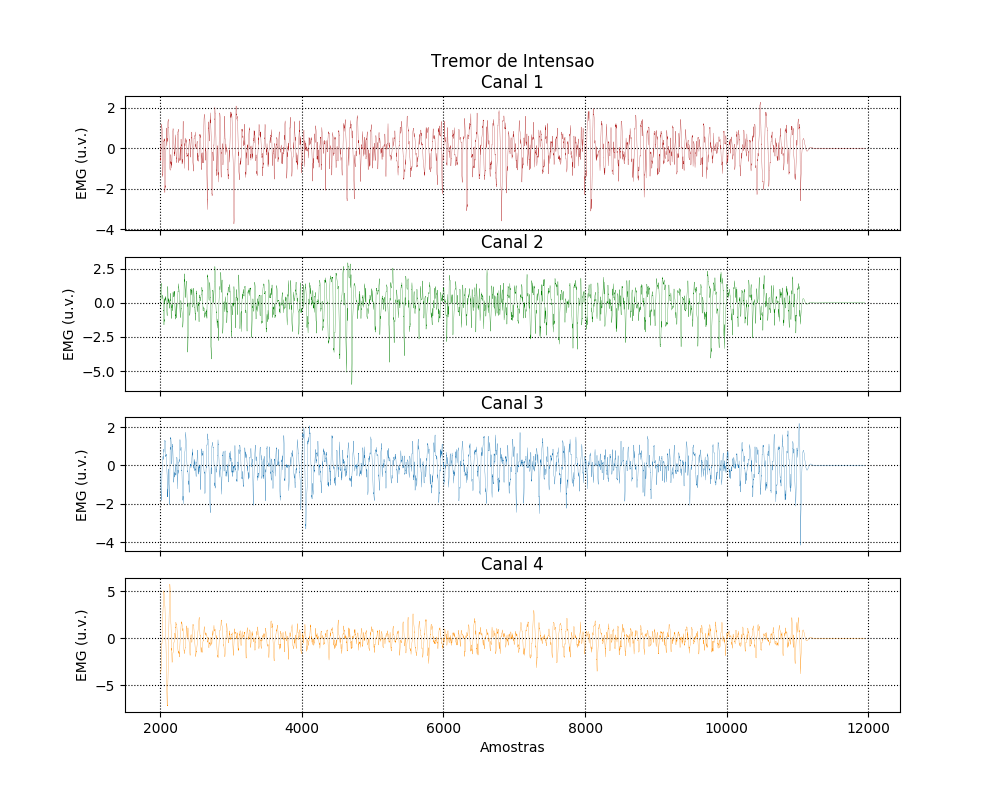

In [65]:
PlotFile(dfn)

In [86]:
c = np.load('DB_REPO/preproc/Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_rms.npy')
PlotFft(c, 50)

<IPython.core.display.Javascript object>

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [75]:
for i in files:
    Xc = Fft(i)
    np.save('./DB_REPO/preproc/'+i+'_fft', Xc, allow_pickle=False)
    print i+'_fft.npy'

Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_fft.npy
Arthur Araujo Filho - Dia 17.11.18 as 16.12.49.edf_fft.npy
Arthur Araujo Filho - Dia 17.11.18 as 16.13.01.edf_fft.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf_fft.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.26.edf_fft.npy
Boanerges Ramos Cunha - Dia 17.11.11 as 16.38.46.edf_fft.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.36.47.edf_fft.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.37.03.edf_fft.npy
Carmino Pereira da Silva - Dia 17.11.18 as 15.37.25.edf_fft.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.34.34.edf_fft.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.34.49.edf_fft.npy
Diniz Esmeraldo - Dia 17.11.08 as 16.35.03.edf_fft.npy
Donia Aires - Dia 17.11.25 as 16.39.51.edf_fft.npy
Donia Aires - Dia 17.11.25 as 16.40.23.edf_fft.npy
Donia Aires - Dia 17.11.25 as 16.40.42.edf_fft.npy
Fernando Francisco da Silva - Dia 17.11.18 as 17.05.58.edf_fft.npy
Fernando Francisco da Silva - Dia 17.11.18 as 17.06.14.edf_fft.

In [77]:
c = np.load('DB_REPO/preproc/Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_fft.npy')

dff = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dff.head()

,Ch1,Ch2,Ch3,Ch4
0,83175.300000,31503.679104,64245.622857,85142.152672
1,35594.691359,12367.931209,44455.620186,39285.893634
2,57290.183123,5324.741546,89391.768584,35538.258799
3,36185.811721,7167.004118,26367.619636,56738.077665
4,22033.382078,4793.733812,28252.036321,34124.670679


<IPython.core.display.Javascript object>


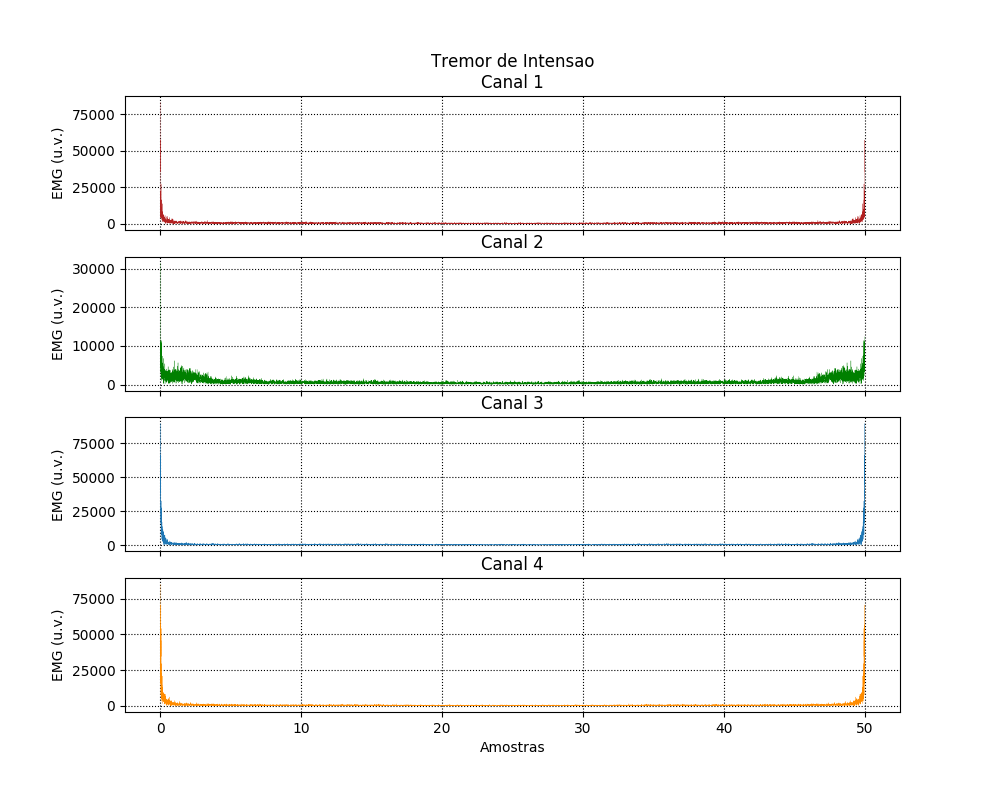

In [78]:
PlotFft(dff,50)

In [79]:
X = Fft('Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf')

In [80]:
X.head()

,Ch1,Ch2,Ch3,Ch4
0,83175.300000,31503.679104,64245.622857,85142.152672
1,35594.691359,12367.931209,44455.620186,39285.893634
2,57290.183123,5324.741546,89391.768584,35538.258799
3,36185.811721,7167.004118,26367.619636,56738.077665
4,22033.382078,4793.733812,28252.036321,34124.670679


<IPython.core.display.Javascript object>


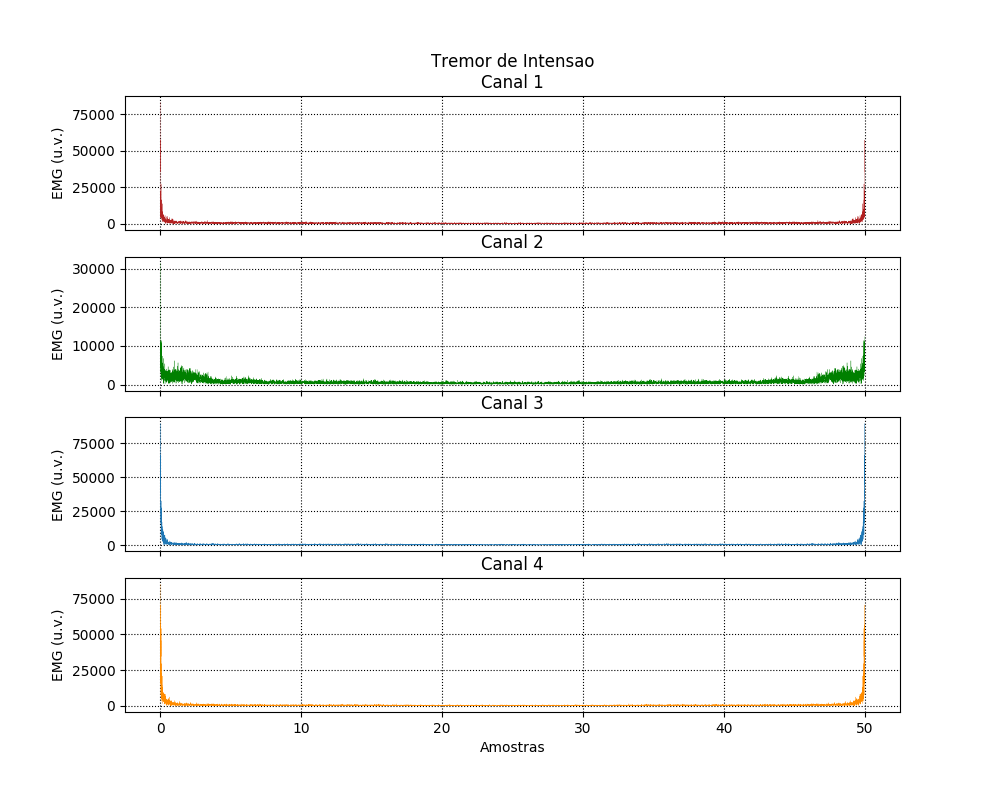

In [81]:
PlotFft(X,50)

In [82]:
import pyeeg

ImportError: No module named pyeeg

In [83]:
X = df['Ch2']


In [114]:
D = pyeeg.first_order_diff(X)
x = pyeeg.hfd(X,13)
x

0.20614155444373494

In [101]:
y = fs = np.linspace(0, 1,len(x))
pyplot.figure(figsize=(10,6))
pyplot.plot(y, x)

TypeError: object of type 'numpy.float64' has no len()

---

---

# Testes com Peaks Detection

        Ch1       Ch2       Ch3       Ch4
0  0.177580  0.159890 -0.286540  0.051892
1  0.137408  0.217005 -0.212902 -0.126882
2  0.147789  0.318284 -0.122926 -0.406303
3  0.282882  0.487074 -0.007218 -0.741849
4  0.552582  0.706690  0.125195 -0.980704


<IPython.core.display.Javascript object>


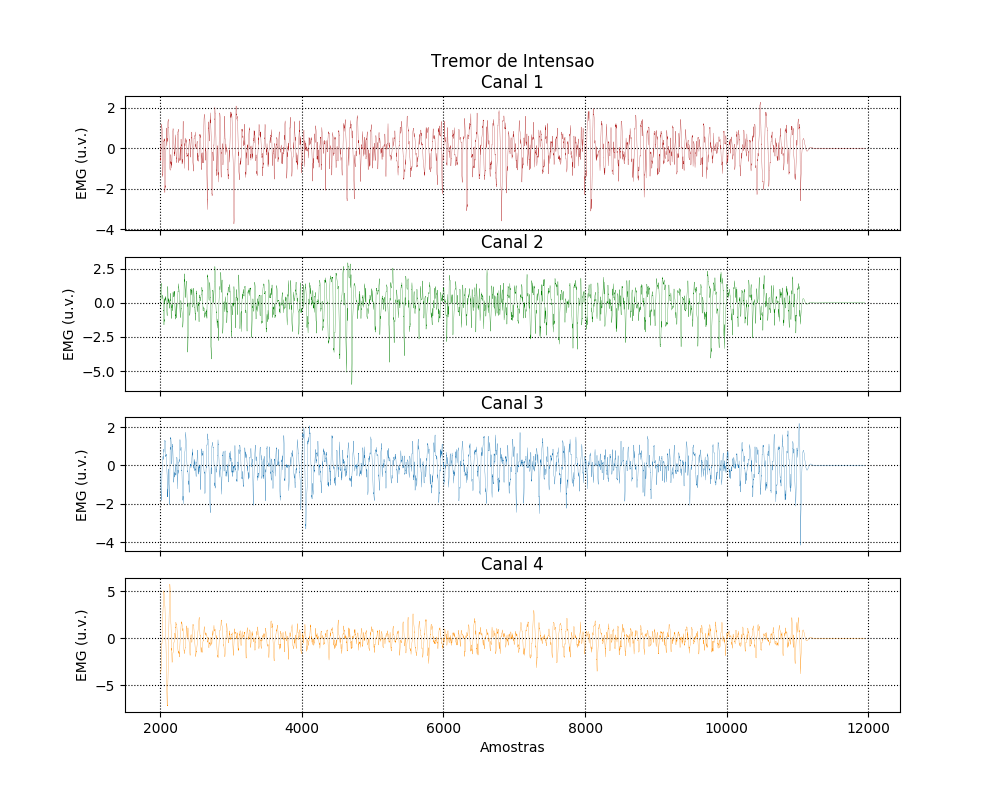

In [84]:
c = np.load('DB_REPO/preproc/Arthur Araujo Filho - Dia 17.11.18 as 16.12.34.edf_filt.npy')

df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
print df.head()
PlotFile(df)

<IPython.core.display.Javascript object>


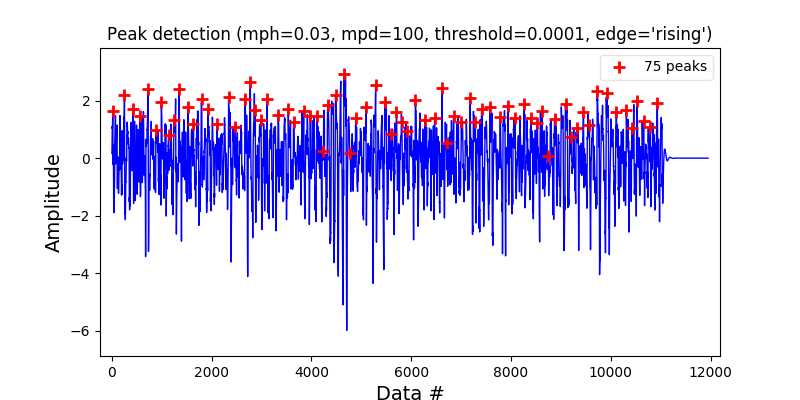

<IPython.core.display.Javascript object>


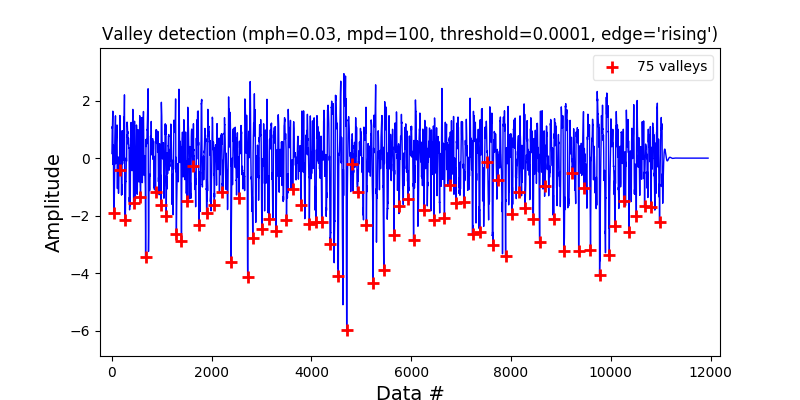

Total de picos: 150


In [85]:
peak_p = detect_peaks(df['Ch2'][:20000], mph=0.03, mpd=100, threshold=0.0001, valley=False, show=True)
peak_n = detect_peaks(df['Ch2'][:20000], mph=0.03, mpd=100, threshold=0.0001, valley=True, show=True)

Peaks = len(peak_p) + len(peak_n)
print ('Total de picos: %.i' % Peaks)

        Ch1       Ch2       Ch3       Ch4
0 -0.020852  0.117666 -0.028383 -0.010453
1 -0.093391  0.113990 -0.673404 -0.005585
2 -0.163355  0.203198 -1.089419  0.005687
3 -0.208123  0.348138 -1.278355  0.000582
4 -0.220727  0.441619 -1.389578 -0.043104


<IPython.core.display.Javascript object>


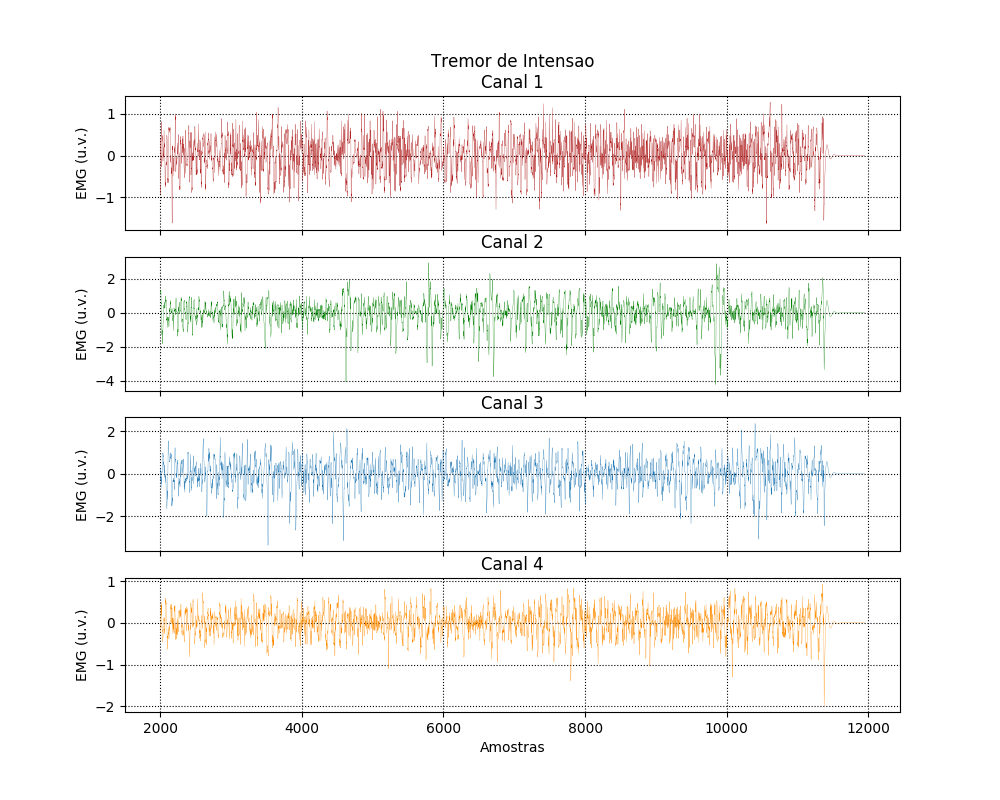

In [87]:
c = np.load('DB_REPO/preproc/Boanerges Ramos Cunha - Dia 17.11.11 as 16.37.53.edf_filt.npy')

df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
print df.head()
PlotFile(df)

<IPython.core.display.Javascript object>


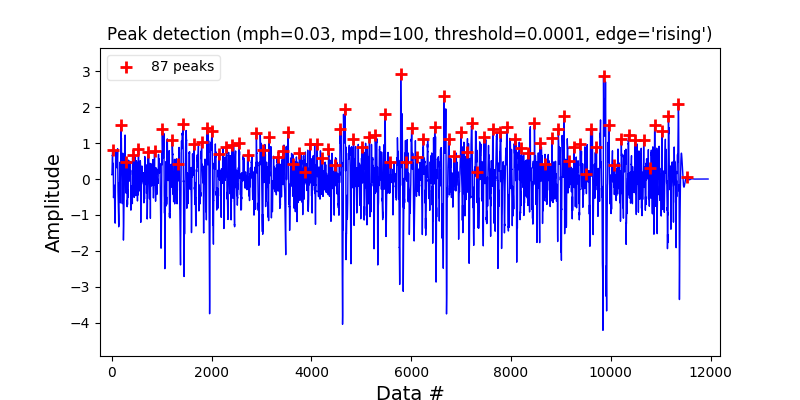

<IPython.core.display.Javascript object>


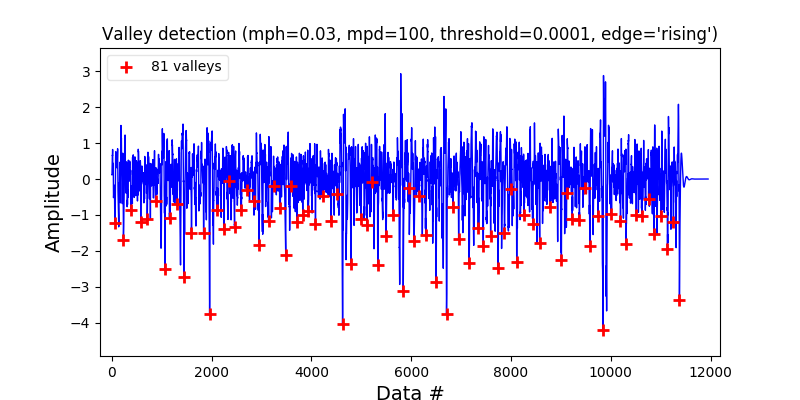

Total de picos: 168


In [88]:
peak_p = detect_peaks(df['Ch2'][:20000], mph=0.03, mpd=100, threshold=0.0001, valley=False, show=True)
peak_n = detect_peaks(df['Ch2'][:20000], mph=0.03, mpd=100, threshold=0.0001, valley=True, show=True)

Peaks = len(peak_p) + len(peak_n)
print ('Total de picos: %.i' % Peaks)

## Testes com PeakUtils

In [91]:
import peakutils
len(peakutils.indexes(df['Ch2'], thres=0.5, min_dist=30))

ImportError: No module named peakutils

In [90]:
y = df['Ch2']
x = fs = np.linspace(0, 1,df['Ch2'].shape[0])

<IPython.core.display.Javascript object>


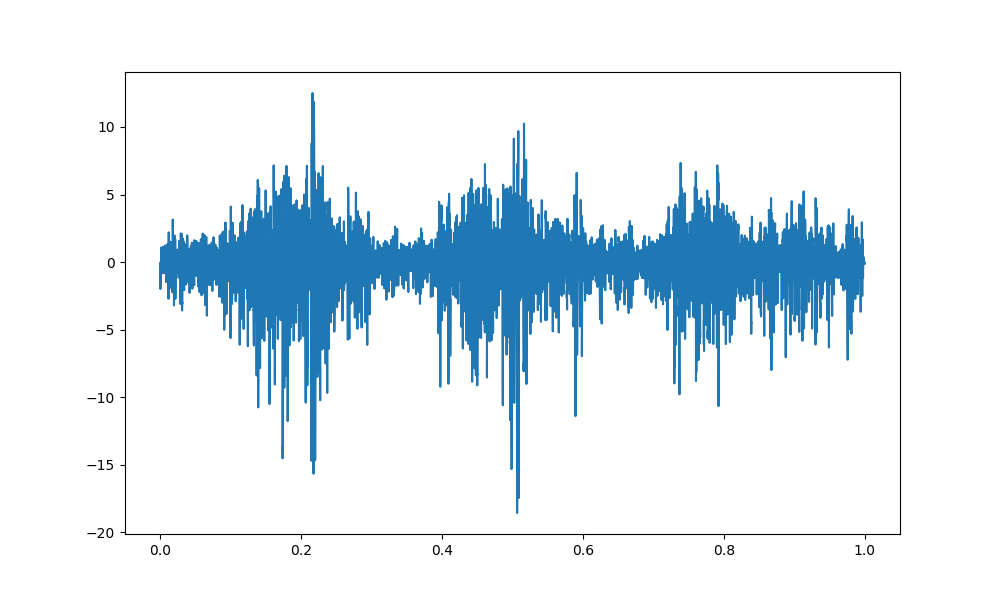

In [84]:
from peakutils.plot import plot as pplot
from matplotlib import pyplot

pyplot.figure(figsize=(10,6))
pyplot.plot(x, y)


<IPython.core.display.Javascript object>


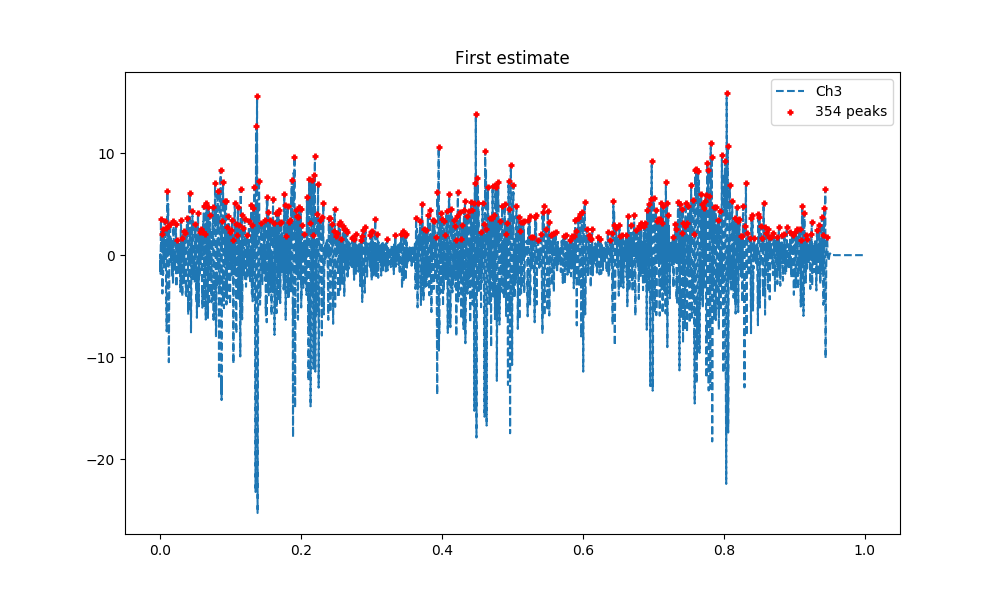

In [45]:
indexes = peakutils.indexes(y, thres=0.65, min_dist=30)

pyplot.figure(figsize=(10,6))
pplot(x, y, indexes)
pyplot.title('First estimate')